In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [2]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="qwen2.5-coder:14b", temperature=0)

In [3]:
from langgraph.graph import StateGraph, START, END

def chatbot(state: State):
    return { "messages": [llm.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile()

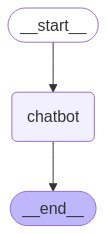

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [5]:
question = "What's Gemma 3 ?"

In [6]:
def run(question: str):
    for event in graph.stream({"messages": [{"role": "user", "content": question}]}):
        for val in event.values():
            print("AI: ", val["messages"][-1].content)

In [7]:
run(question)

AI:  I'm sorry, but I couldn't find any information about "Gemma 3". It might be a specific product, service, or technology that is not widely recognized or documented in public resources. If you have more context or details about what Gemma 3 refers to, I would be better able to assist you. Could you please provide additional information?


## USE TOOL

In [11]:
from langchain_community.tools import DuckDuckGoSearchResults

search_tool = DuckDuckGoSearchResults(num_results=2)

In [12]:
# TEST
search_tool.invoke(question)

"snippet: What's new in Gemma? Link to Youtube Video (visible only when JS is disabled) Gemma 3 introduces multimodality, supporting vision-language input and text outputs. It handles context windows up to 128k tokens, understands over 140 languages, and offers improved math, reasoning, and chat capabilities, including structured outputs and function ..., title: Introducing Gemma 3: The Developer Guide- Google Developers Blog, link: https://developers.googleblog.com/en/introducing-gemma3/, snippet: What is Gemma 3? Gemma 3 is Google's latest iteration of open weight LLMs. It comes in four sizes, 1 billion, 4 billion, 12 billion, and 27 billion parameters with base (pre-trained) and instruction-tuned versions. Gemma 3 goes multimodal!The 4, 12, and 27 billion parameter models can process both images and text, while the 1B variant is text only.. The input context window length has been ..., title: Welcome Gemma 3: Google's all new multimodal, multilingual, long ..., link: https://hugging

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tools = [search_tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return { "messages": [llm_with_tools.invoke(state["messages"])]}

tools_node = ToolNode(tools=tools)

In [20]:
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", tools_node)
builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
builder.add_edge("tools", "chatbot")
graph = builder.compile()

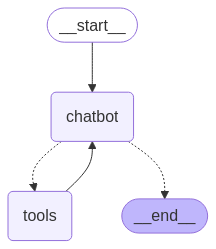

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [22]:
run(question)

AI:  
AI:  snippet: Gemma 3 is the latest version of the Gemma family of open models, which can handle vision-language input and text outputs, and understand over 140 languages. Learn how to use Gemma 3 for text and image tasks, fine-tune it for your domains, and explore its features and applications., title: Introducing Gemma 3: The Developer Guide- Google Developers Blog, link: https://developers.googleblog.com/en/introducing-gemma3/, snippet: Gemma 3 is a family of open weight language models that can process images and text, and support 140+ languages. Learn about its features, technical enhancements, evaluation, and inference with 🤗 transformers., title: Welcome Gemma 3: Google's all new multimodal, multilingual, long ..., link: https://huggingface.co/blog/gemma3
AI:  Gemma 3 is the latest version of the Gemma family of open models. It can handle vision-language input and text outputs, and understand over 140 languages. You can use it for various tasks such as text and image proce

## ACTIVATE MEMORY

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory_saver = MemorySaver()

In [24]:
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", tools_node)
builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
builder.add_edge("tools", "chatbot")
graph = builder.compile(checkpointer=memory_saver)

In [25]:
config = {"configurable": {"thread_id": "1"}}

In [26]:
def run_with_memory(question: str):
    for val in graph.stream({"messages": [{"role": "user", "content": question}]}, config, stream_mode="values"):
        val["messages"][-1].pretty_print()

In [28]:
user_input = "Hello, my name is huo"

In [29]:
run_with_memory(user_input)

================================ Human Message =================================

Hello, my name is huo
================================== Ai Message ==================================

Hello Huo! How can I assist you today? If you have any questions or need information on a specific topic, feel free to ask.


In [30]:
user_follow_up = "You still remember my name ?"
run_with_memory(user_follow_up)

================================ Human Message =================================

You still remember my name ?
================================== Ai Message ==================================

Yes, I remember your name is Huo. How can I help you today?


In [31]:
state_snapshot = graph.get_state(config)
state_snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hello, my name is huo', additional_kwargs={}, response_metadata={}, id='ae5848a3-6a92-4d0d-9041-4132235adb70'), AIMessage(content='Hello Huo! How can I assist you today? If you have any questions or need information on a specific topic, feel free to ask.', additional_kwargs={}, response_metadata={'model': 'qwen2.5-coder:14b', 'created_at': '2025-04-21T11:39:30.092604309Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2250670508, 'load_duration': 1600613123, 'prompt_eval_count': 188, 'prompt_eval_duration': 138000000, 'eval_count': 30, 'eval_duration': 507000000, 'message': {'role': 'assistant', 'content': 'Hello Huo! How can I assist you today? If you have any questions or need information on a specific topic, feel free to ask.', 'images': None, 'tool_calls': None}}, id='run-ed64570b-4894-4a16-a6de-0bd9777b9426-0', usage_metadata={'input_tokens': 188, 'output_tokens': 30, 'total_tokens': 218}), HumanMessage(content='You